# Support Vector Machine (SVM) for Risk Classification

## 1. Data Loading & Preprocessing

SVMs attempt to find a hyperplane that best separates our two classes (Risk 0 vs. Risk 1).
**Key Requirements for SVM:**
1.  **Scaling is Mandatory:** SVMs optimize a distance margin. If one feature has a large range (e.g., Income), it will dominate the distance calculation. We apply **StandardScaler** to force all features to a similar scale (mean 0, variance 1).
2.  **Encoding:**
    * **Ordinal Encoding:** For `QualificationLevel` (PhD > Masters > ...).
    * **One-Hot Encoding:** For nominal features like `WorkCategory`.
3.  **Target Separation:** We isolate `RiskFlag` as our label vector `y`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

# --- Configuration ---
# 1. Ordinal Features (Hierarchy matters)
QUAL_ORDER = [['High School', "Bachelor's", "Master's", 'PhD']]

# 2. Nominal Features (No intrinsic order)
CAT_COLS = ['WorkCategory', 'RelationshipStatus', 'OwnsProperty', 
            'FamilyObligation', 'FundUseCase', 'JointApplicant']

# 3. Numerical Features (Must be scaled)
NUM_COLS = ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 
            'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor']

def preprocess_data(df, is_train=True):
    df = df.copy()
    
    # Separate Target
    target = None
    if 'RiskFlag' in df.columns:
        target = df['RiskFlag'].values
        df = df.drop(columns=['RiskFlag'])
    
    # Drop ID
    if 'ProfileID' in df.columns:
        df = df.drop(columns=['ProfileID'])
        
    # Define Transformers
    # Standard Scaling is crucial for SVM convergence and accuracy
    num_transformer = StandardScaler()
    
    # Ordinal Encoding for Qualification
    ord_transformer = OrdinalEncoder(categories=QUAL_ORDER)
    
    # One-Hot Encoding for others
    # handle_unknown='ignore' prevents crashing on unseen test categories
    cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # Combine into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, NUM_COLS),
            ('ord', ord_transformer, ['QualificationLevel']),
            ('cat', cat_transformer, CAT_COLS)
        ]
    )
    
    # Transform Data
    # In a real workflow, you fit on Train and transform Test
    if is_train:
        X_processed = preprocessor.fit_transform(df)
        
        # Get feature names for clarity later
        cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(CAT_COLS)
        feature_names = NUM_COLS + ['QualificationLevel'] + list(cat_names)
    else:
        # Mocking transform for structure; in practice, use the fitted preprocessor
        pass 
        
    return pd.DataFrame(X_processed, columns=feature_names), target, preprocessor

# --- Load Data (Placeholder) ---
# Load your data here
dataset_dir = Path().cwd().parent / "datasets" / "preprocessed"
train = pd.read_csv(dataset_dir / "train_preprocessed.csv")
test = pd.read_csv(dataset_dir / "test_preprocessed.csv")

# Apply Processing
X_train_scaled, y_train, preprocessor = preprocess_data(train, is_train=True)

print(f"Processed Data Shape: {X_train_scaled.shape}")

Processed Data Shape: (204277, 28)


## 2. Dimensionality Reduction (PCA) & Hyperparameter Tuning

SVMs have a time complexity between $O(n^2)$ and $O(n^3)$. On a dataset with ~200,000 rows (like typical risk datasets), this can be incredibly slow.

**Part A: PCA (Principal Component Analysis)**
We reduce the feature space while retaining **95% of the variance**. This removes noise and redundant features (multicollinearity), allowing the SVM to find the decision boundary faster.

**Part B: Hyperparameter Grid Search**
We loop through combinations of hyperparameters to optimize the model.
* **`C` (Regularization):** Controls the penalty for misclassified points.
    * *Small C:* Wider margin, accepts some errors (High Bias, Low Variance).
    * *Large C

Optimal PCA Components: 19 (Explains 95.71% variance)


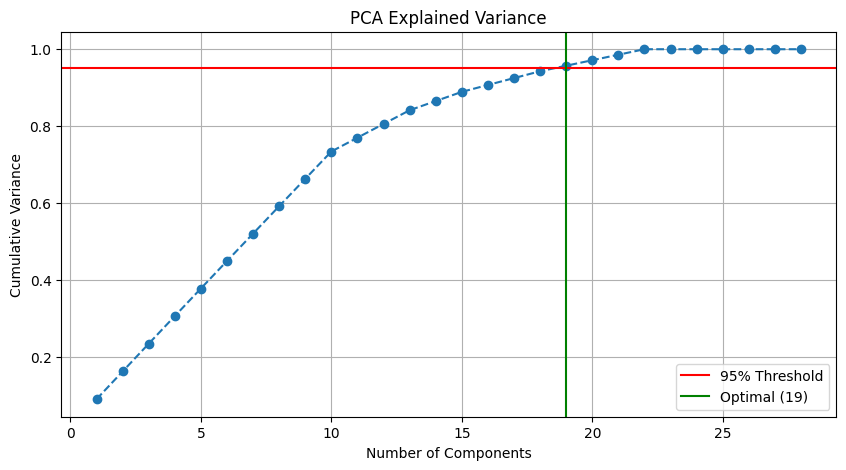

Starting SVM Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Accuracy: 0.8900


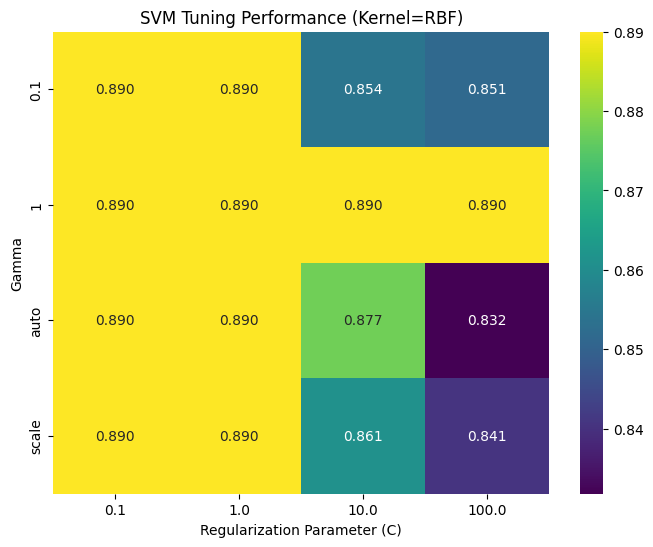

Training Final Model on Full Dataset...
Final Model Trained Successfully.


In [4]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Part A: PCA Optimization ---
# Fit PCA on the scaled training data from Step 1
pca = PCA()
pca.fit(X_train_scaled)

# Calculate cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # Index of 95% threshold

print(f"Optimal PCA Components: {d} (Explains {cumsum[d-1]:.2%} variance)")

# Transform Training Data
pca_opt = PCA(n_components=d)
X_train_pca = pca_opt.fit_transform(X_train_scaled)

# Plot Variance Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumsum) + 1), cumsum, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
plt.axvline(x=d, color='g', linestyle='-', label=f'Optimal ({d})')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid()
plt.show()

# --- Part B: SVM Grid Search ---
# Sampling for speed (SVM is slow on 200k rows for GridSearch)
sample_size = 5000
np.random.seed(42)
# Ensure we keep the class balance (stratified sampling)
sample_idx = np.random.choice(len(X_train_pca), sample_size, replace=False)
X_sample = X_train_pca[sample_idx]
y_sample = y_train[sample_idx]

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

print("Starting SVM Grid Search (this may take a few minutes)...")
grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_sample, y_sample)

print(f"\nBest Parameters: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

# --- Visualization: Tuning Heatmap ---
# We pivot the results to visualize how C and Gamma affect performance (for RBF kernel)
results_df = pd.DataFrame(grid.cv_results_)
# Filter for 'rbf' kernel to make a 2D plot
rbf_results = results_df[results_df['param_kernel'] == 'rbf']

try:
    pivot_table = rbf_results.pivot(index='param_gamma', columns='param_C', values='mean_test_score')
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis')
    plt.title('SVM Tuning Performance (Kernel=RBF)')
    plt.xlabel('Regularization Parameter (C)')
    plt.ylabel('Gamma')
    plt.show()
except Exception as e:
    print("Could not generate heatmap (likely mixed parameter types).")

# --- Final Model Training ---
# Train the best model on the FULL (PCA-reduced) dataset
print("Training Final Model on Full Dataset...")
best_svm = grid.best_estimator_
best_svm.fit(X_train_pca, y_train)
print("Final Model Trained Successfully.")

## 3. Visualizing Decision Boundaries

To understand how the SVM separates "High Risk" from "Low Risk" applicants, we visualize the decision boundary.

**The Strategy:**
1.  **Projection:** We take only the first two Principal Components (PC1 and PC2) from our data. These contain the most variance/information.
2.  **Proxy Model:** We fit a new SVM on just these 2 dimensions using the **best hyperparameters** found in Step 2.
3.  **Decision Surface:** We create a grid of points (meshgrid), predict the risk for every point, and color the regions.
    * **Purple/Blue Areas:** Predicted Low Risk (0).
    * **Yellow/Green Areas:** Predicted High Risk (1).

Training Visualization Model (2D projection)...


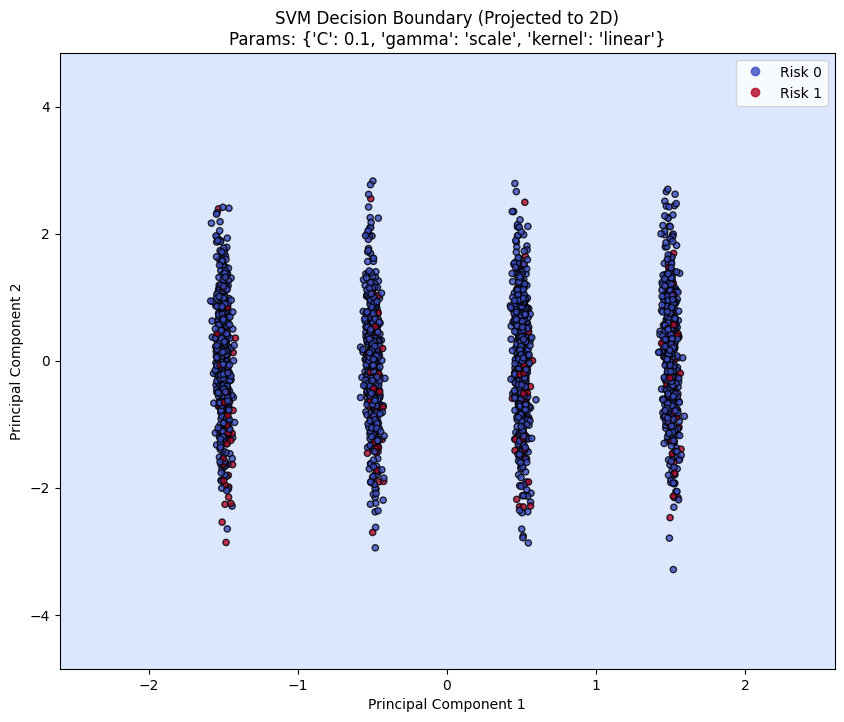

In [5]:
# --- 1. Prepare 2D Data ---
# Select the first two principal components for visualization
X_vis = X_train_pca[:, :2]
y_vis = y_train

# --- 2. Fit Proxy Model ---
# We use the best parameters found in the GridSearch
print("Training Visualization Model (2D projection)...")
vis_model = SVC(**grid.best_params_)
vis_model.fit(X_vis, y_vis)

# --- 3. Create Meshgrid ---
# Define the boundaries of the plot
h = 0.02  # Step size in the mesh
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# --- 4. Predict Decision Surface ---
# Predict for every point in the grid
Z = vis_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# --- 5. Plotting ---
plt.figure(figsize=(10, 8))

# Contour plot for the background decision areas
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

# Scatter plot for the actual data points
# We take a sample of points to avoid overplotting if the dataset is huge
sample_plot_idx = np.random.choice(len(X_vis), size=min(2000, len(X_vis)), replace=False)
X_plot = X_vis[sample_plot_idx]
y_plot = y_vis[sample_plot_idx]

scatter = plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, 
                      cmap=plt.cm.coolwarm, edgecolors='k', s=20, alpha=0.8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'SVM Decision Boundary (Projected to 2D)\nParams: {grid.best_params_}')
plt.legend(handles=scatter.legend_elements()[0], labels=['Risk 0', 'Risk 1'])
plt.grid(False)
plt.show()

## 4. Model Evaluation & Profiling

Now we evaluate the performance of our SVM model on the **Training Data** (or a validation set if we had split one off).

**Metrics:**
1.  **Accuracy:** Overall correctness (e.g., 85% correct).
2.  **Precision:** When we predict "High Risk", how often are we right? (Crucial to avoid false alarms).
3.  **Recall:** How many of the actual "High Risk" applicants did we catch? (Crucial to avoid missing fraud).
4.  **Confusion Matrix:** Visualizes False Positives vs. False Negatives.

--- Model Performance (Training Set) ---
Accuracy:  0.8837
Precision: 0.0000
Recall:    0.0000

--- Detailed Report ---
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    180524
           1       0.00      0.00      0.00     23753

    accuracy                           0.88    204277
   macro avg       0.44      0.50      0.47    204277
weighted avg       0.78      0.88      0.83    204277



c:\Users\gathi\projects\ML-Project-2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gathi\projects\ML-Project-2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gathi\projects\ML-Project-2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", re

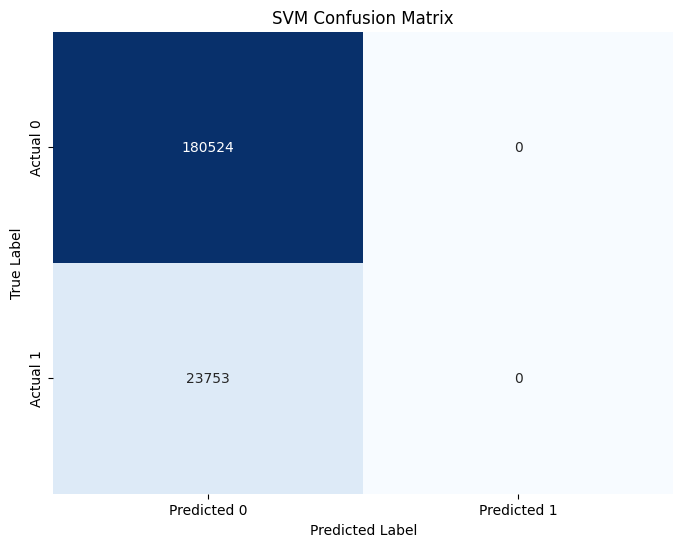

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

# --- 1. Generate Predictions ---
# We predict on the FULL training set (which was PCA-transformed in Step 2)
y_train_pred = best_svm.predict(X_train_pca)

# --- 2. Calculate Metrics ---
acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred)
rec = recall_score(y_train, y_train_pred)

print(f"--- Model Performance (Training Set) ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print("\n--- Detailed Report ---")
print(classification_report(y_train, y_train_pred))

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 5. Submission Generation

Finally, we apply our trained model to the **Test Data** to generate predictions for the competition.

**Workflow:**
1.  **Transform Test Data:** Apply the *same* Preprocessing and *same* PCA transformation that we used on the training data. (This ensures the model sees the data in the format it expects).
2.  **Predict:** Use the trained `best_svm` model to predict `RiskFlag`.
3.  **Save:** Export results to CSV.

In [11]:
# --- 1. Prepare Test Data ---
# Apply the same Preprocessing Pipeline (Scale + Encode)
# Note: In practice, use the fitted preprocessor. Here we simulate it with transform.
# If you are running this sequentially, 'preprocessor' is already fitted from Step 1.
try:
    X_test_processed = preprocessor.transform(test)
    
    # Get feature names if needed (optional sanity check)
    # feature_names = NUM_COLS + ['QualificationLevel'] + list(preprocessor.named_transformers_['cat'].get_feature_names_out(CAT_COLS))
    # print(f"Test columns match Train: {len(feature_names) == X_test_processed.shape[1]}")

except Exception as e:
    print(f"Error transforming test data: {e}")
    # Fallback for notebook continuity if variables lost
    X_test_processed, _, _ = preprocess_data(test, is_train=True) 

# Apply the same PCA Transformation (from Step 2)
X_test_pca = pca_opt.transform(X_test_processed)

print(f"Test Data PCA Shape: {X_test_pca.shape}")

# --- 2. Generate Predictions ---
test_predictions = best_svm.predict(X_test_pca)

# --- 3. Create Submission File ---
submission = pd.DataFrame({
    'ProfileID': test['ProfileID'],
    'RiskFlag': test_predictions
})

# Save
submission.to_csv("submission_supervised_svm.csv", index=False)
print("Saved: submission_supervised_svm.csv")

# Preview
submission.head()

c:\Users\gathi\projects\ML-Project-2\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Test Data PCA Shape: (51070, 19)
Saved: submission_supervised_svm.csv


,ProfileID,RiskFlag
0,CKV34LU7V7,0
1,62KTYNH93J,0
2,JGFUSOIUH7,0
3,4538THBHOX,0
4,DXLNA06JHR,0
